In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.metrics import accuracy_score,r2_score,confusion_matrix,classification_report,recall_score,confusion_matrix,mean_squared_error
from sklearn.linear_model import LogisticRegression,LinearRegression
from sklearn.model_selection import train_test_split,KFold,cross_val_score,ShuffleSplit
from sklearn.neighbors import KNeighborsRegressor
from sklearn import preprocessing
import re
from pandas_profiling import ProfileReport

In [2]:
df = pd.read_csv('Chapter 2 - housing.csv')
df.head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value ocean_proximity  
0       322.0       126.0         8.3252            452600.0        NEAR BAY  
1      2401.0      1138.0         8.3014            358500.0        NEAR BAY  
2       496.0       177.0         7.2574            352100.0        NEAR BAY  
3       558.0       219.0         5.6431            341300.0        NEAR BAY  
4       565.0       259.0         3.8462            342200.0        NEAR BAY

In [3]:
ProfileReport(df)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [4]:
# getting the object columns
strings_columns =  list(df.dtypes[df.dtypes == 'object'].index)
strings_columns
for col in strings_columns:
    print(f"unique values in each string column are: {df[col].unique()}")
    print(f"number of unique values in each string column is: {df[col].nunique()}\n")
    
# getting int or float columns
numeric_columns = list(df.drop(strings_columns,axis=1))
print(len(numeric_columns))


unique values in each string column are: ['NEAR BAY' '<1H OCEAN' 'INLAND' 'NEAR OCEAN' 'ISLAND']
number of unique values in each string column is: 5

9


In [5]:
df.shape

(20640, 10)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


## number of Null values in data set is in total_bedrooms column and it represents approximatly 1 percent from data

In [7]:
(df.isna().sum()/df.shape[0])*100

longitude             0.000000
latitude              0.000000
housing_median_age    0.000000
total_rooms           0.000000
total_bedrooms        1.002907
population            0.000000
households            0.000000
median_income         0.000000
median_house_value    0.000000
ocean_proximity       0.000000
dtype: float64

## i think that dropping null values is the optimal solution as it represents a very small sample from data

In [8]:
df.dropna(inplace=True)

## There are many outliers as seen in the report, and as we will se in the following cells

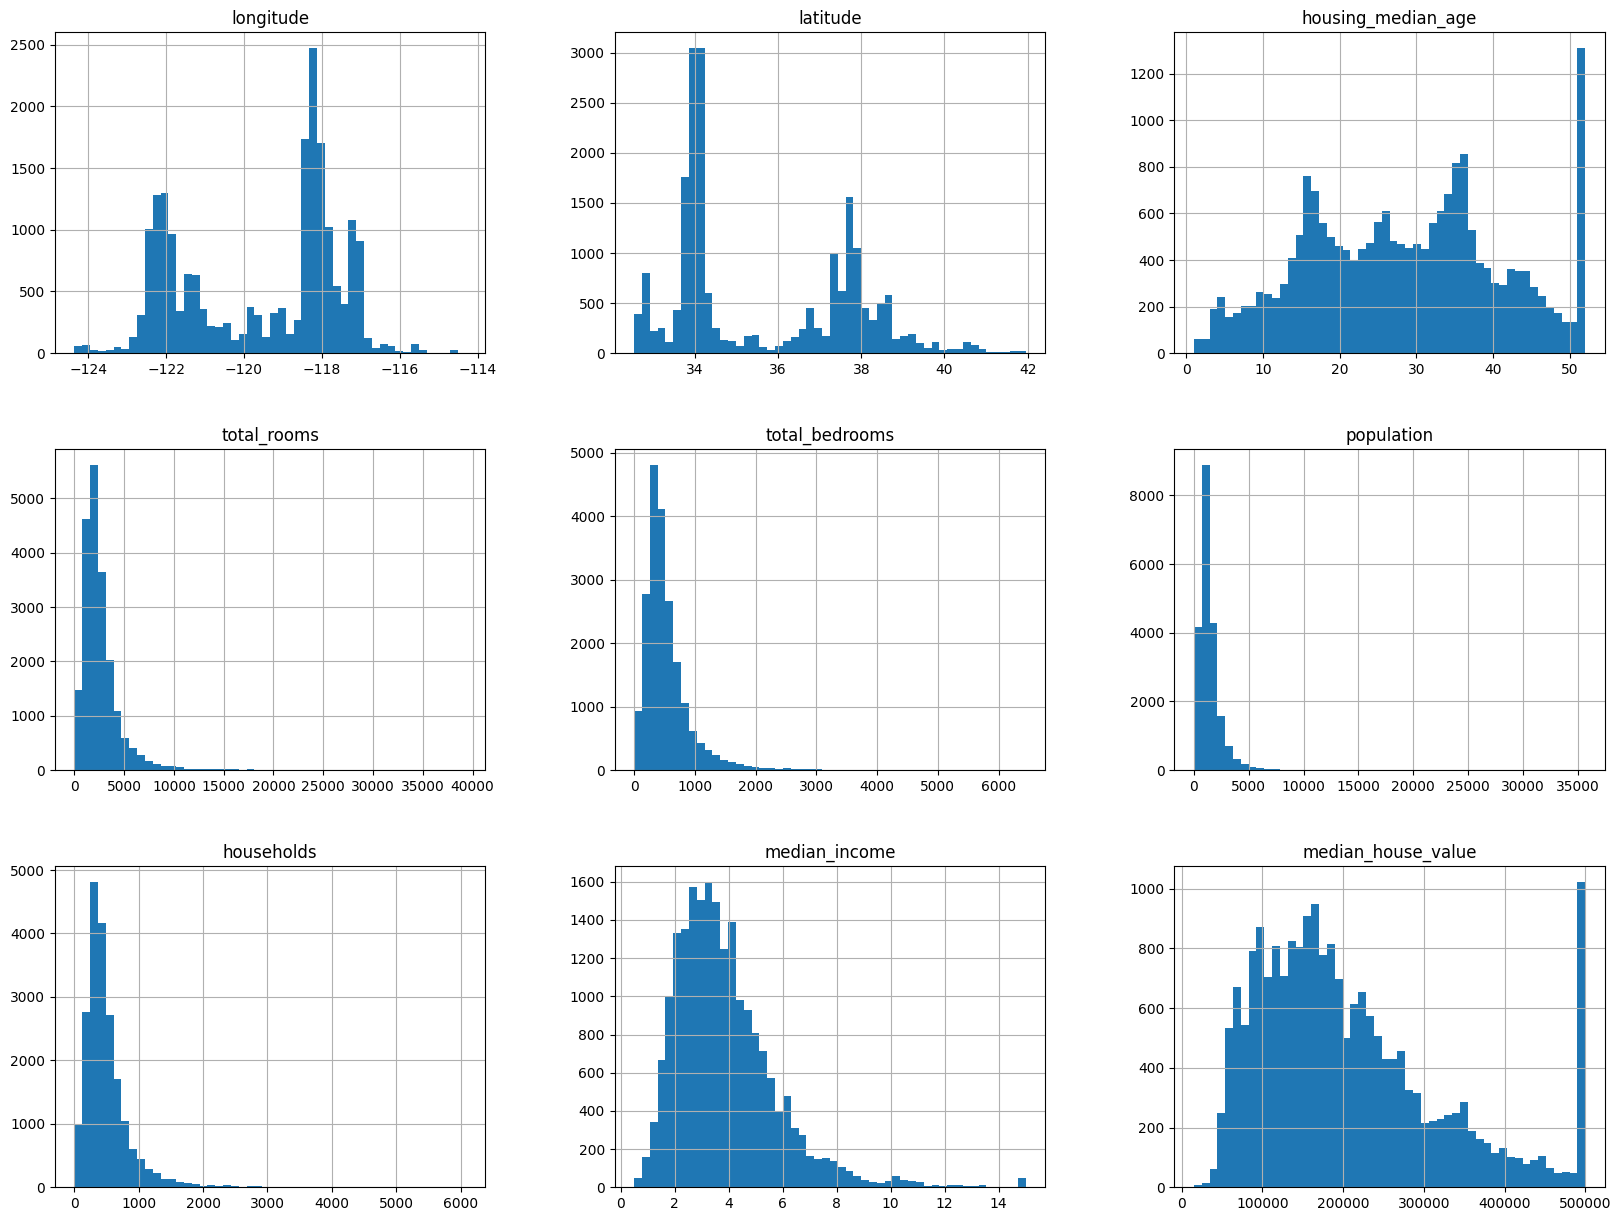

In [9]:
df.hist(bins=50,figsize=(20,15))
plt.show()

In [10]:
# there is no duplicates in data
df.duplicated().sum()

0

## label encoder is good for ordered categorical data, but in this case we will use the one hot encoder which will make a binary columns

In [11]:
ohe = preprocessing.OneHotEncoder()
ocean_proximity_encoded = pd.DataFrame(ohe.fit_transform(df[['ocean_proximity']]).toarray(),columns=['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'])
df = df.drop('ocean_proximity',axis=1)
df = df.join(ocean_proximity_encoded)
#ohe.categories_

In [12]:
df.head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value  <1H OCEAN  \
0       322.0       126.0         8.3252            452600.0        0.0   
1      2401.0      1138.0         8.3014            358500.0        0.0   
2       496.0       177.0         7.2574            352100.0        0.0   
3       558.0       219.0         5.6431            341300.0        0.0   
4       565.0       259.0         3.8462            342200.0        0.0   

   INLAND  ISLAND  NEAR BAY  NEAR OCEAN  
0     0.0     0.0       1.0         0.0  
1     0.0     0.0       1.0         0.0  
2     0.0     0.0       1.0         0.0  
3     0.0     0.0       1.0         0.0  
4     0.0     0.0       1.0         0.0

## correlation between columns and median_house_value	

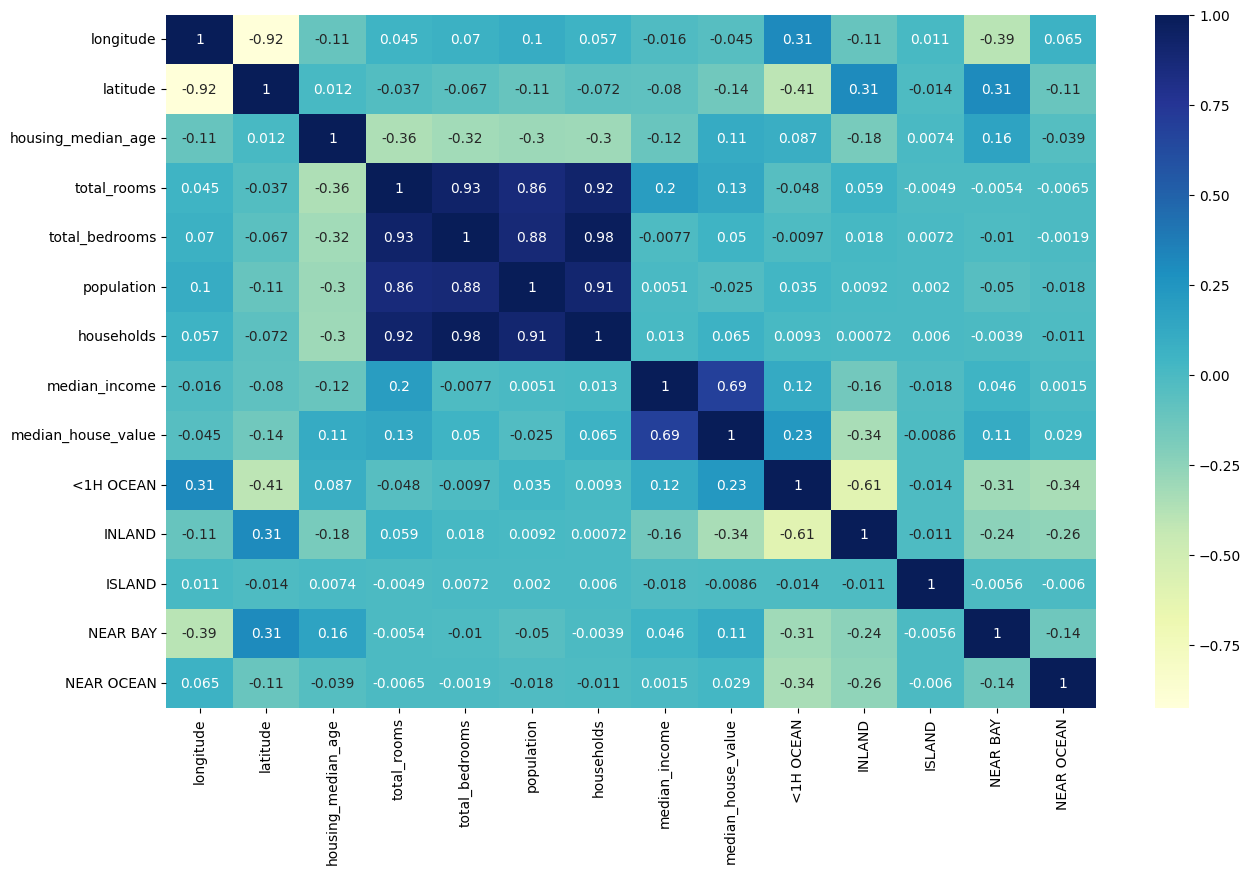

In [13]:
fig , ax = plt.subplots(figsize=(15,9))
sns.heatmap(df.corr(),cmap='YlGnBu',annot=True)
plt.show()

## lets make more columns to see if they will be higher correlated than the primary ones

In [14]:
df['rooms_per_householder'] = df['total_rooms'] / df['households']
df["bedrooms_per_room"] = df["total_bedrooms"]/df["total_rooms"]
df["population_per_household"]=df["population"]/df["households"]

## function to check outliers using box plot<br>

In [15]:
def check_outliers(df):
    for col in numeric_columns:
        fig,ax= plt.subplots(figsize=(15,9))
        plt.grid()
        sns.boxplot(x = df[col])
        plt.show()

## Checking outliers

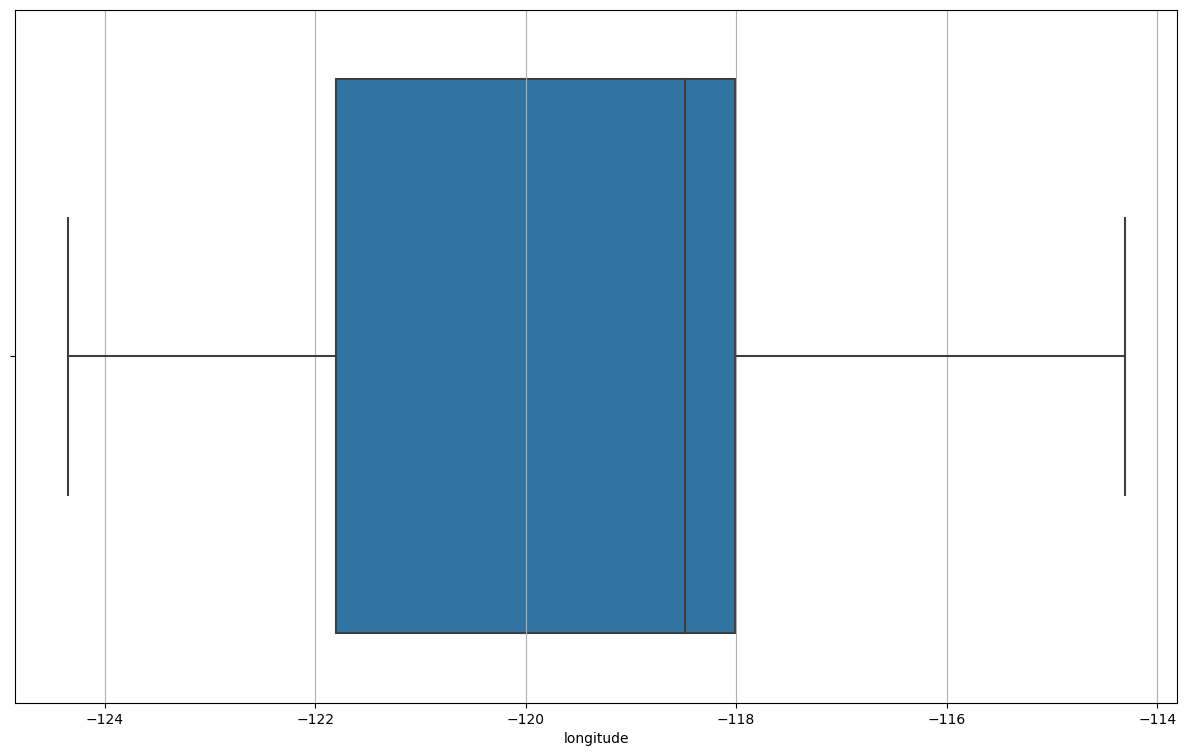

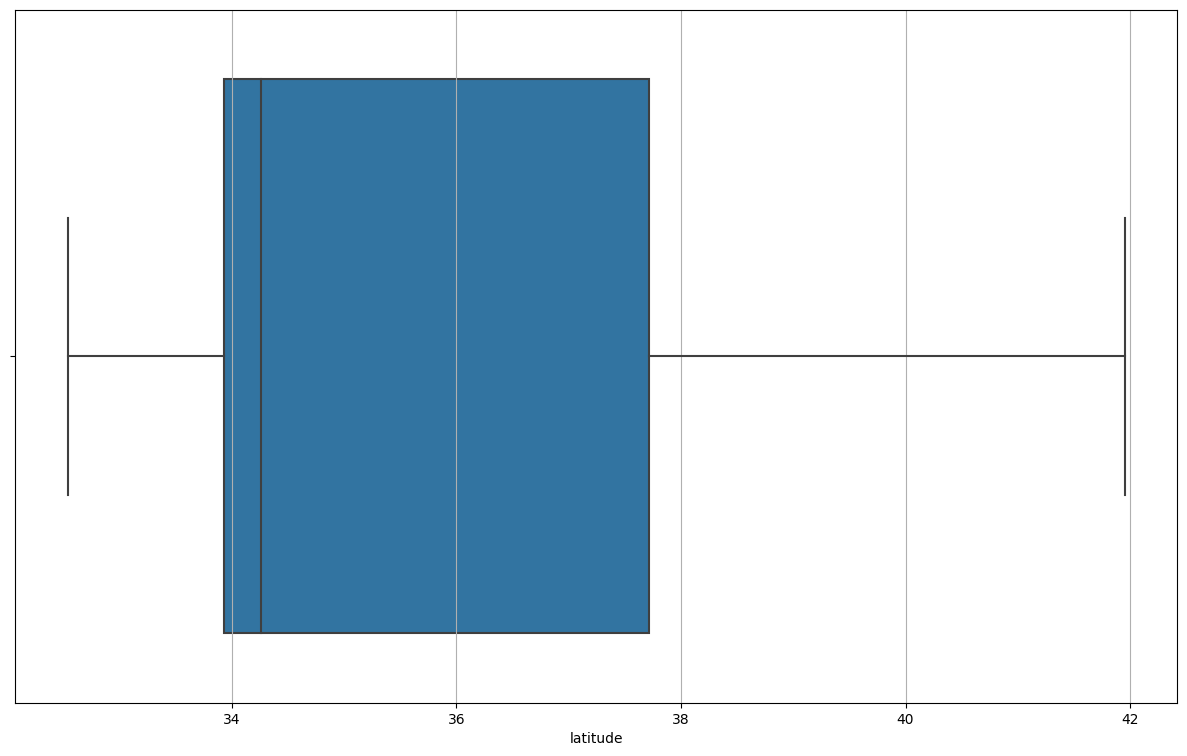

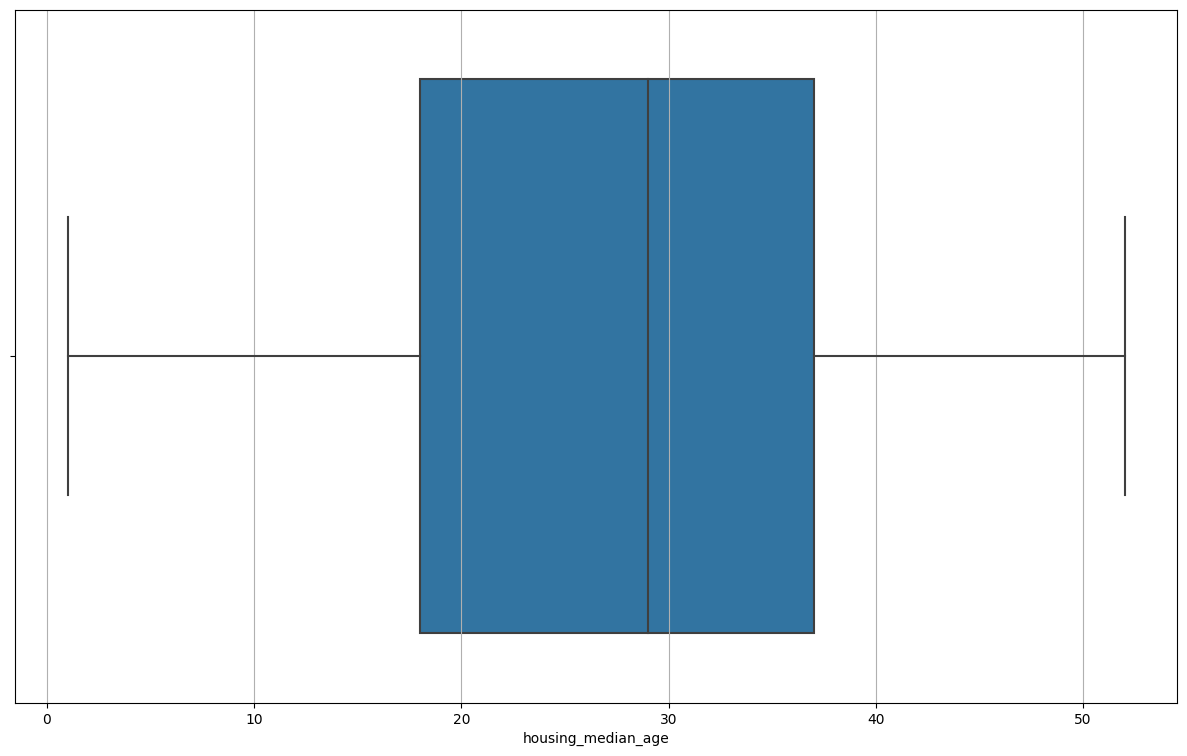

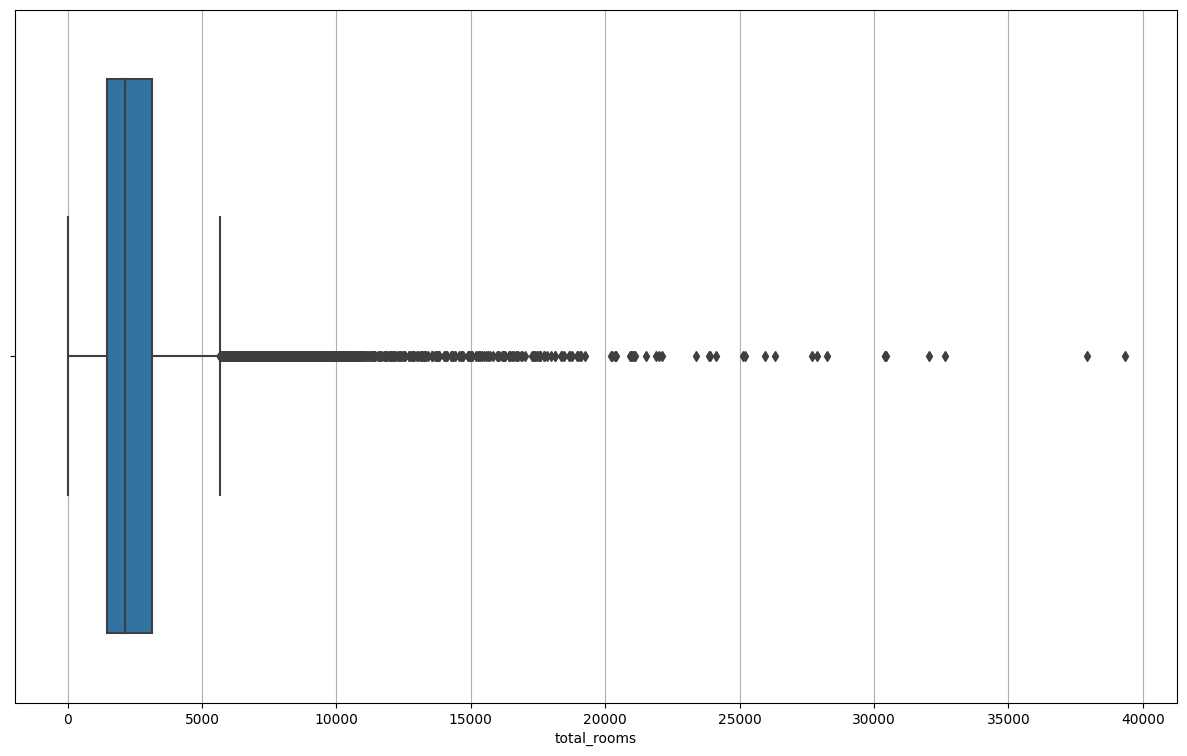

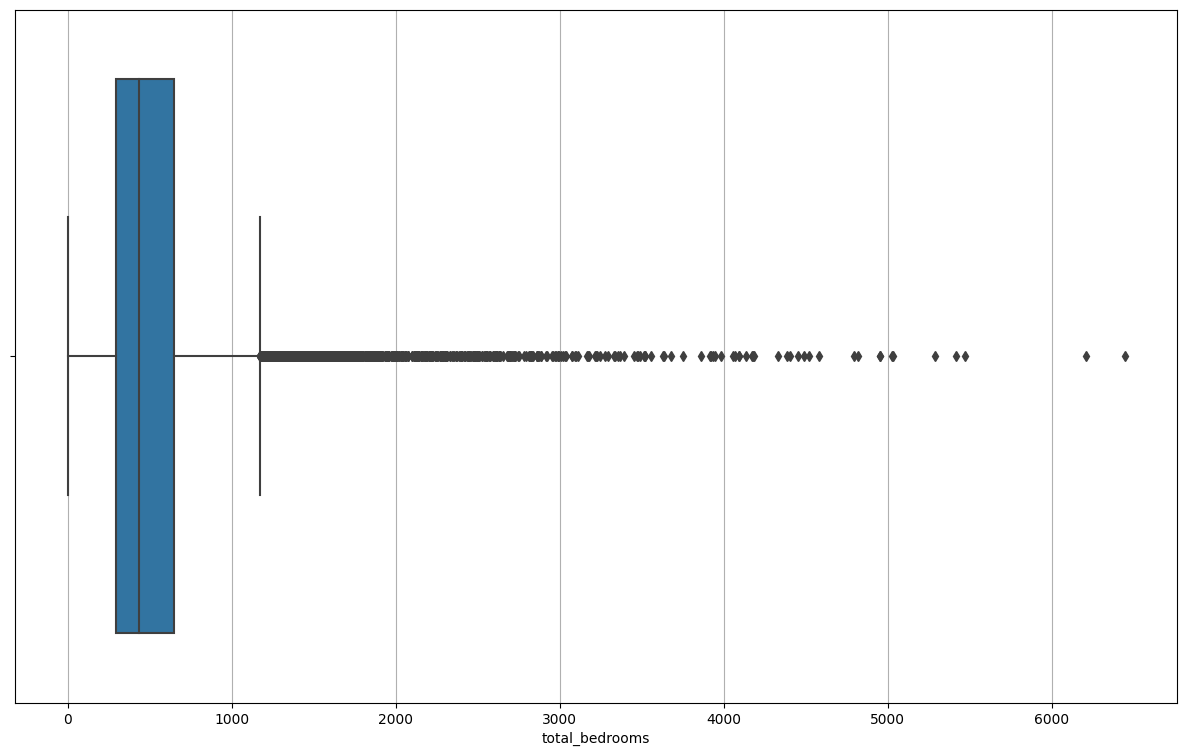

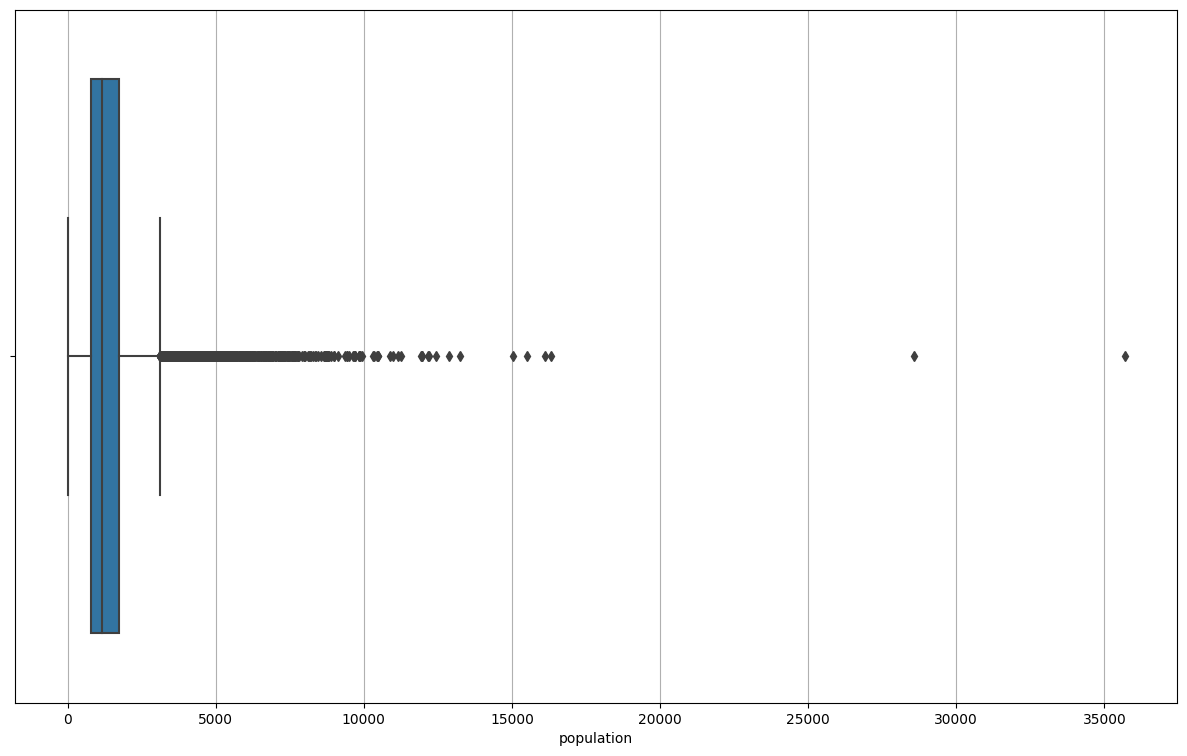

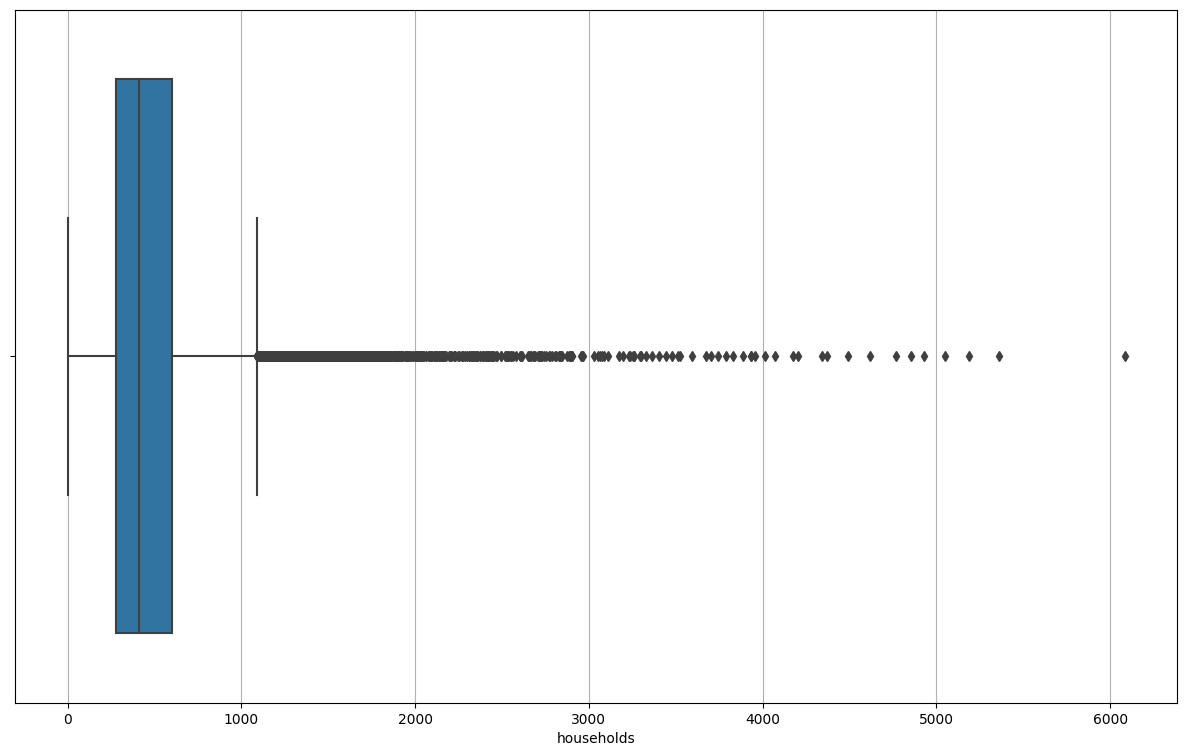

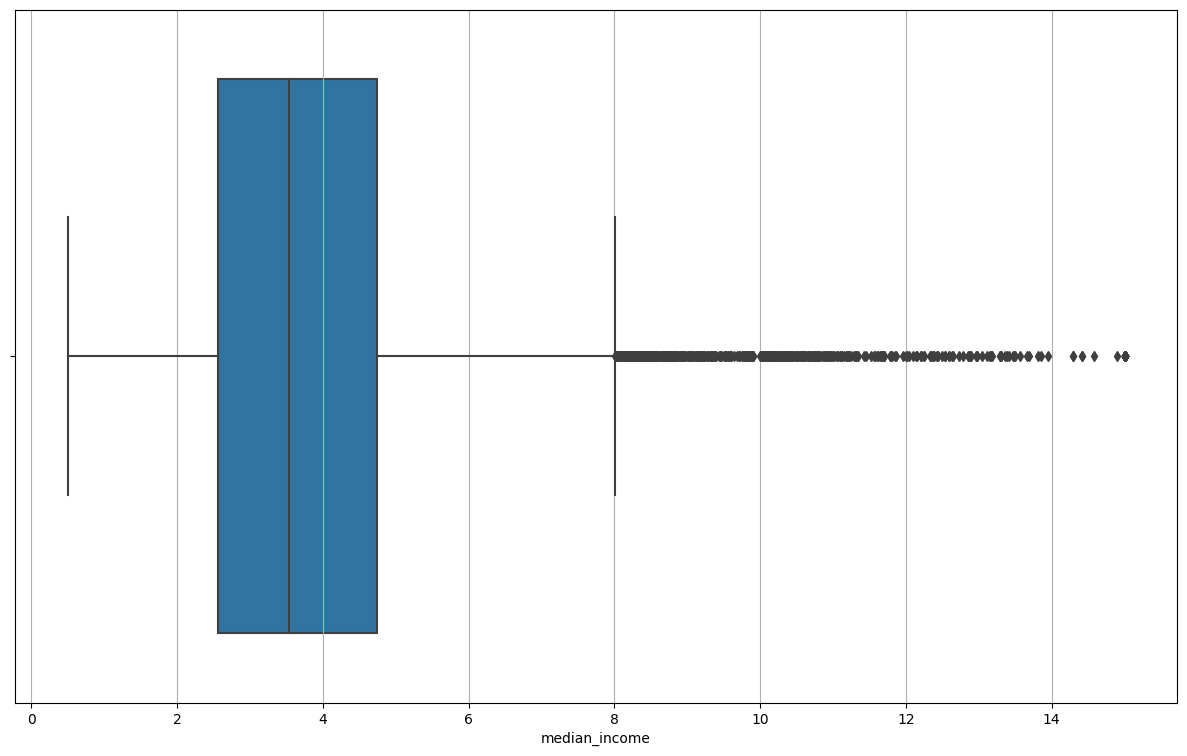

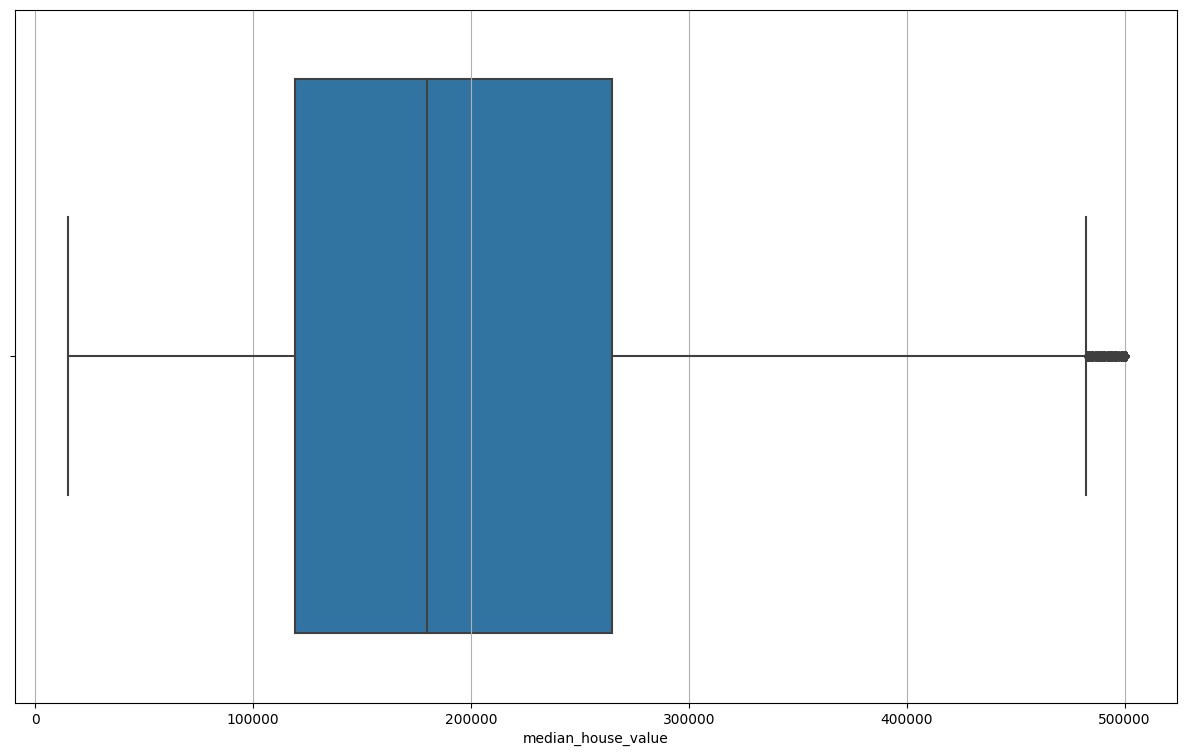

In [16]:
check_outliers(df)

## Handling Outliers

## Function to remove the outliers and it is not the best 

In [29]:
def remove_outliers(df):
    for column in numeric_columns:
        q1 = df[column].quantile(0.25)
        q3 = df[column].quantile(0.75)
        iqr = q3-q1
        upper_lim = q3 + 1.5 * iqr
        lower_lim = q1 - 1.5 * iqr
        outliers_down = (df[column] < lower_lim)
        outliers_up = (df[column] > upper_lim)
        df[column] = df[column][~(outliers_up|outliers_down)]
    return (df)
df = remove_outliers(df)

## Function to replace outliers with mean 

In [17]:
def replace_outliers(df):
    for column in numeric_columns:
        q1 = df[column].quantile(0.25)
        q3 = df[column].quantile(0.75)
        iqr = q3-q1
        upper_lim = q3 + 1.5 * iqr
        lower_lim = q1 - 1.5 * iqr
        column_mean = df[column].mean()
        outliers_down = (df[column] < lower_lim)
        outliers_up = (df[column] > upper_lim)
        df[column] = np.where((df[column] > upper_lim) | (df[column] < lower_lim) , column_mean, df[column])
        df[column] = pd.DataFrame(df[column],columns=[column])
    return (df)
df = replace_outliers(df)

## let's see the outliers after replacing them with mean

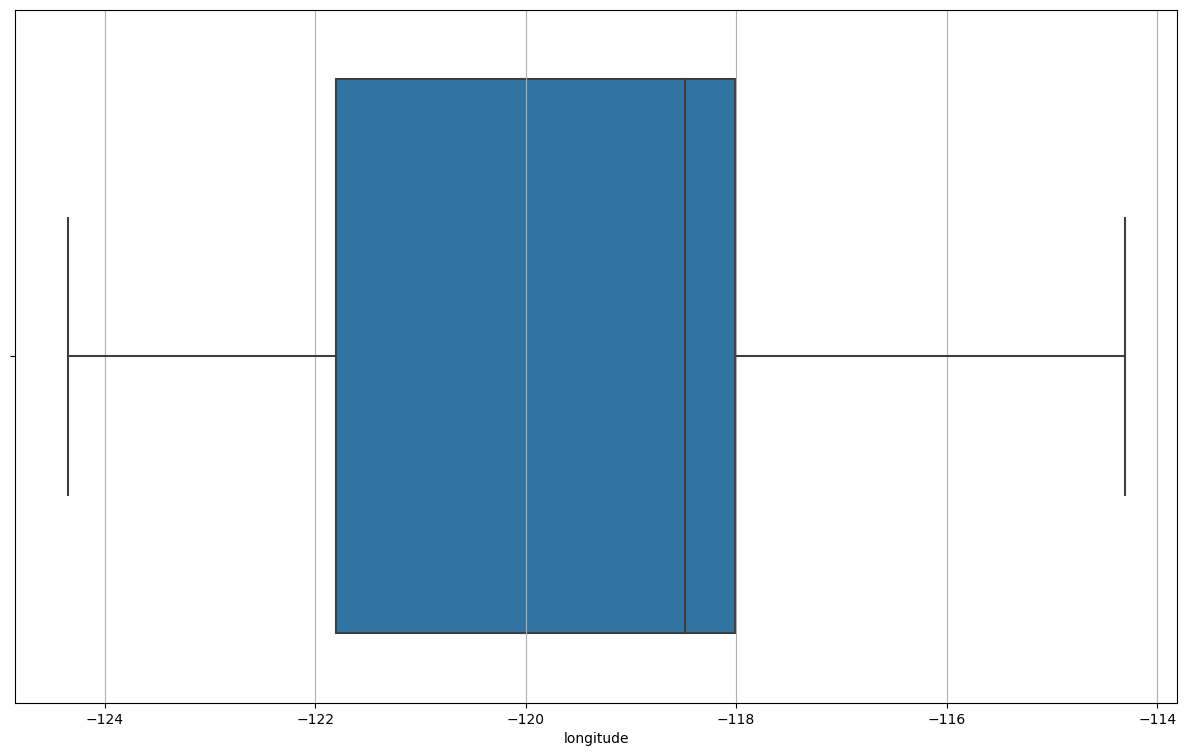

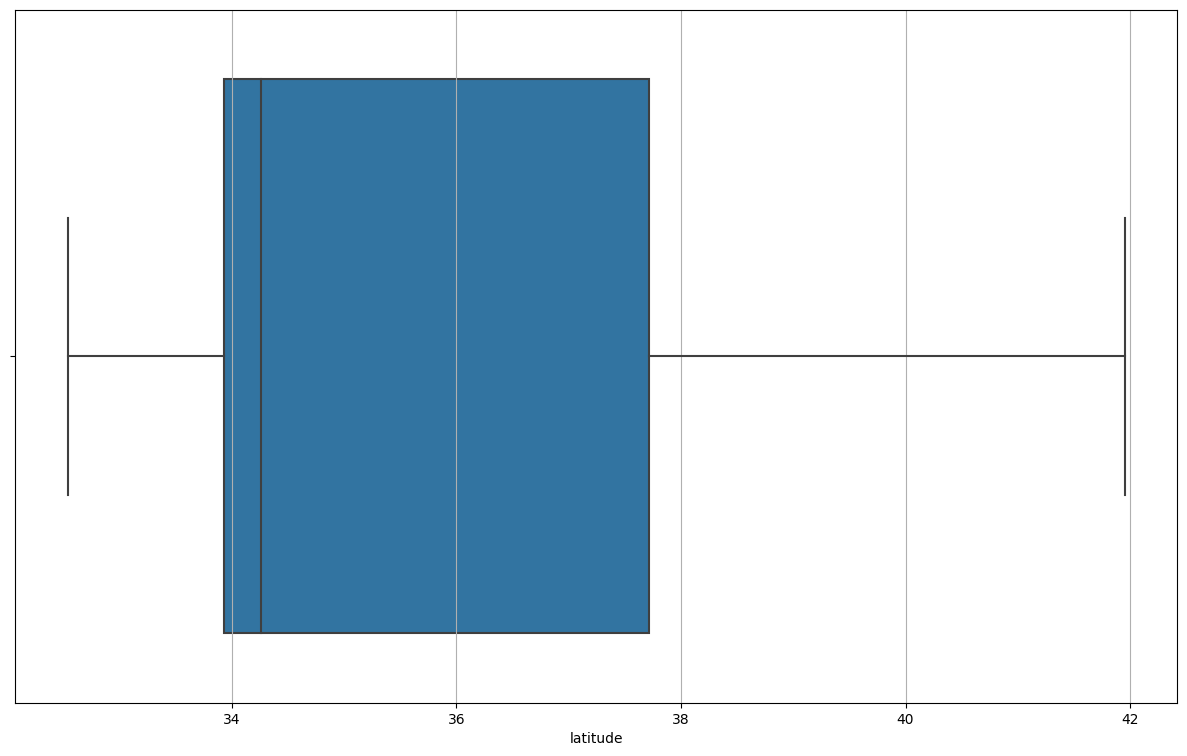

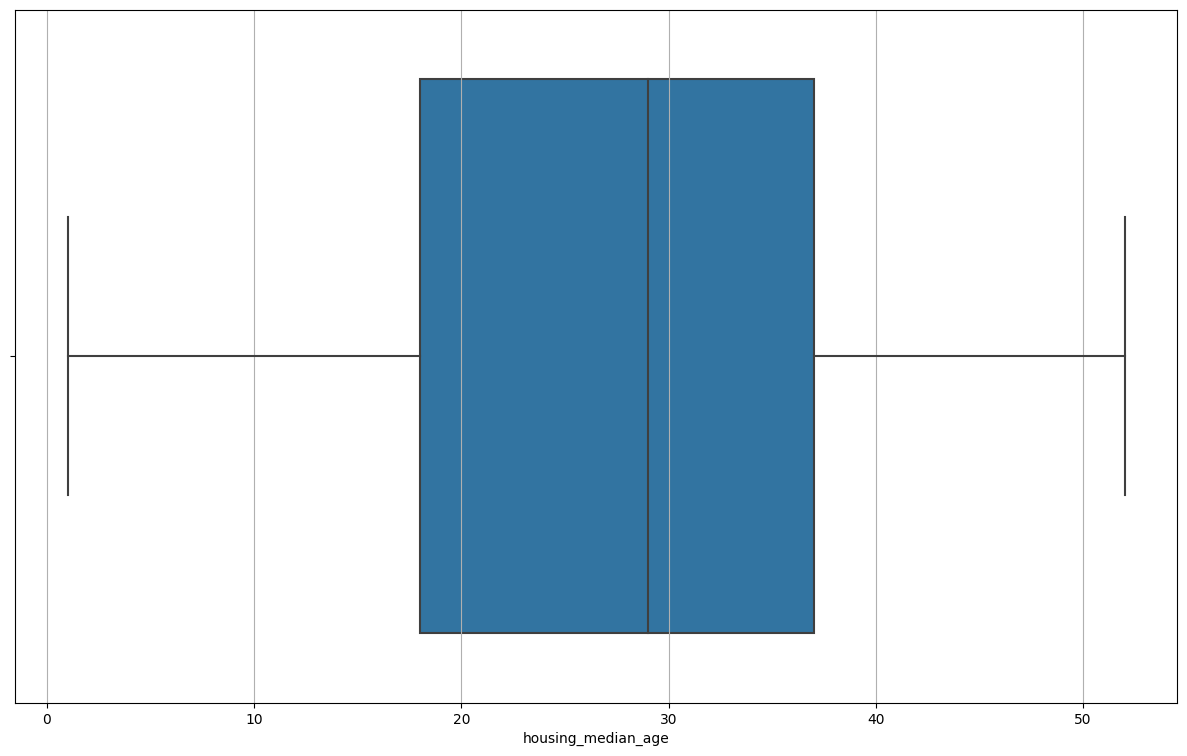

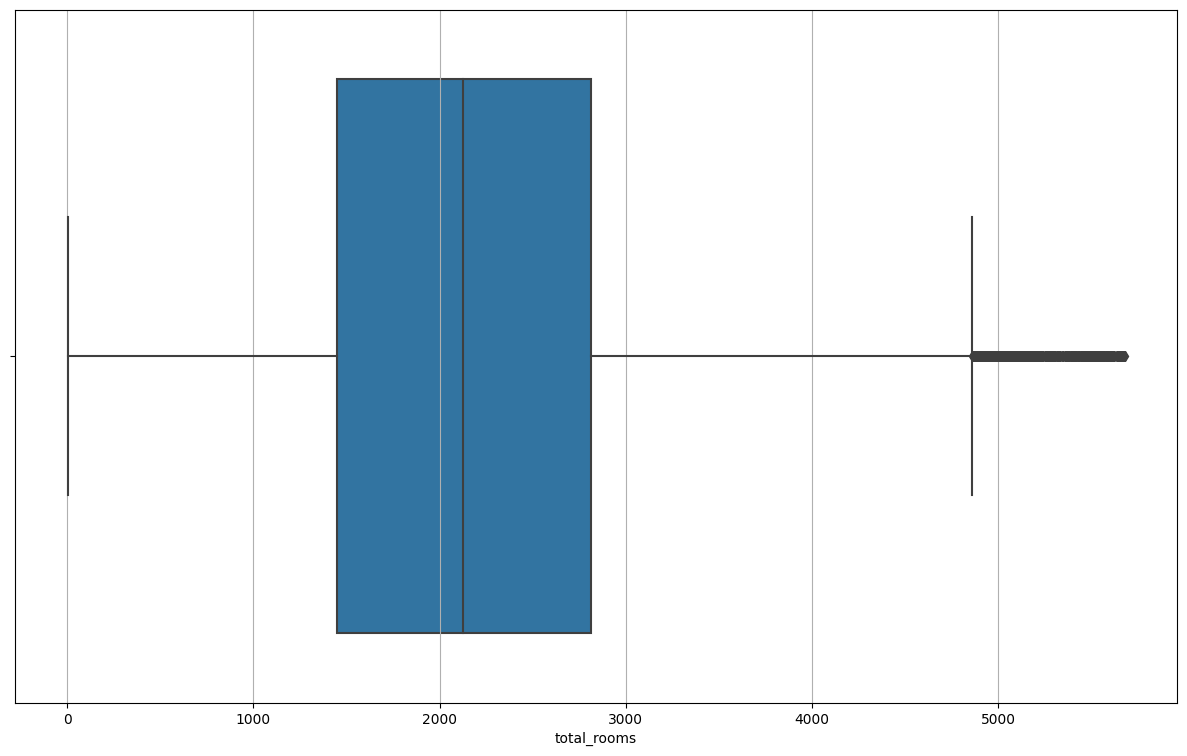

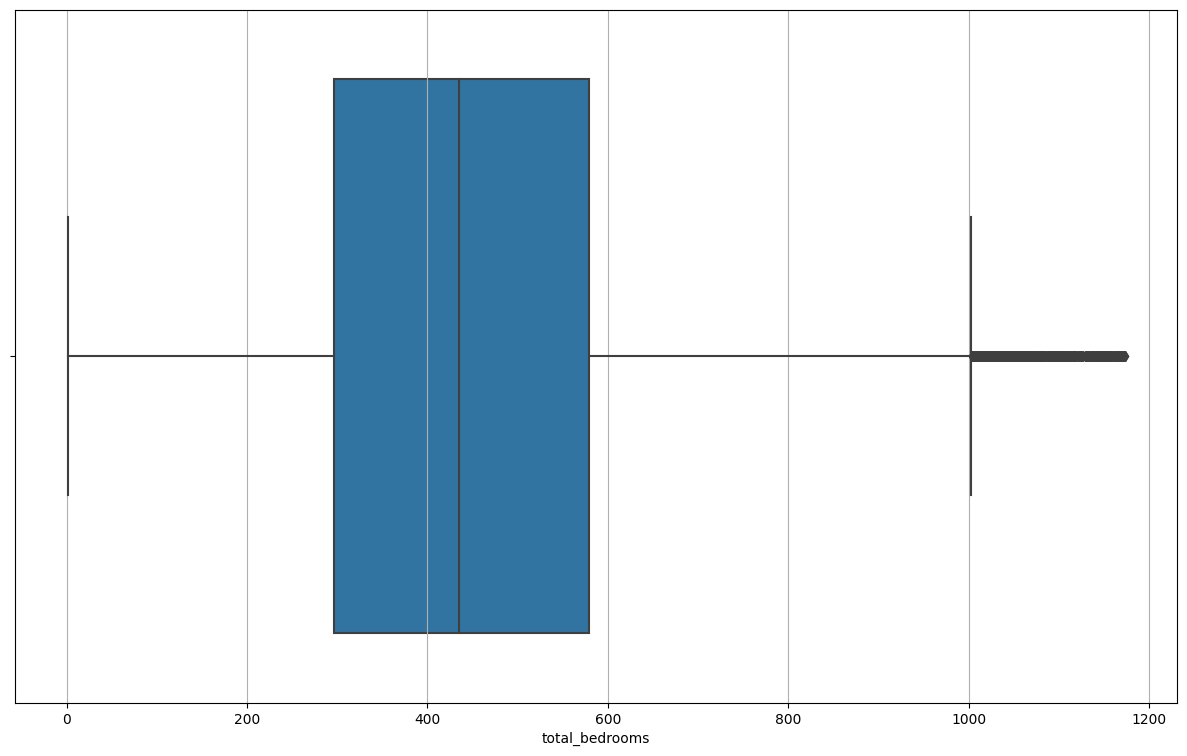

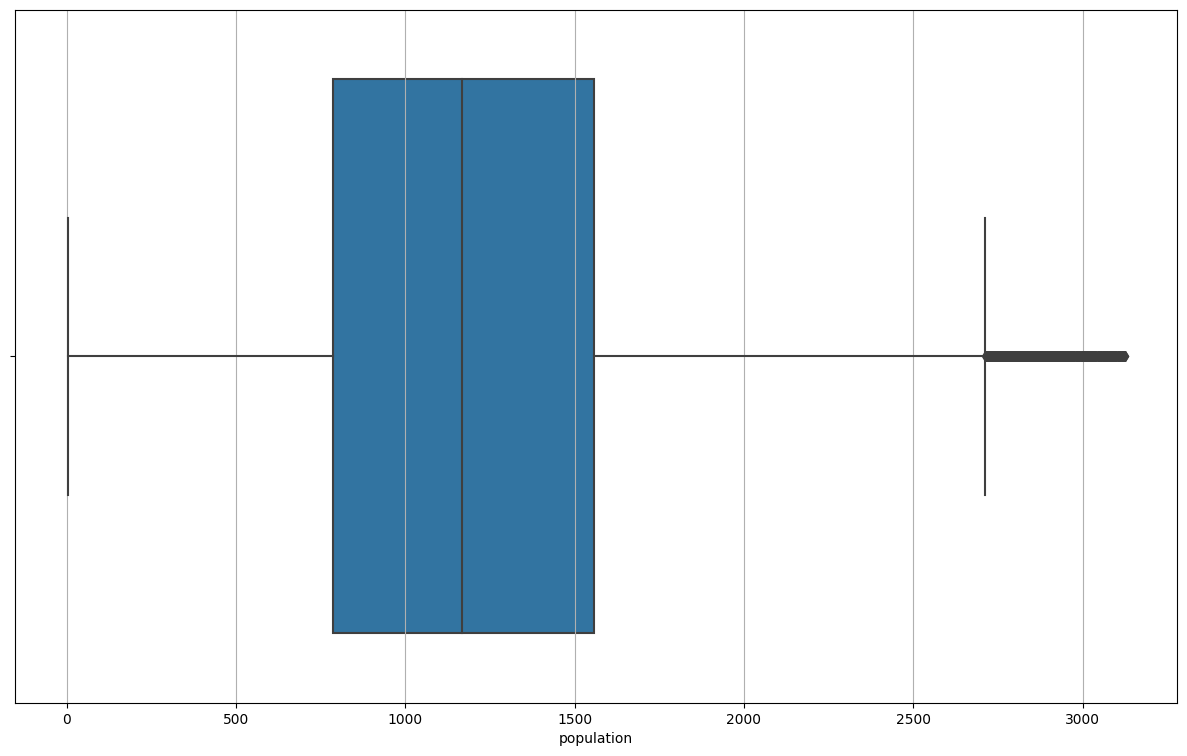

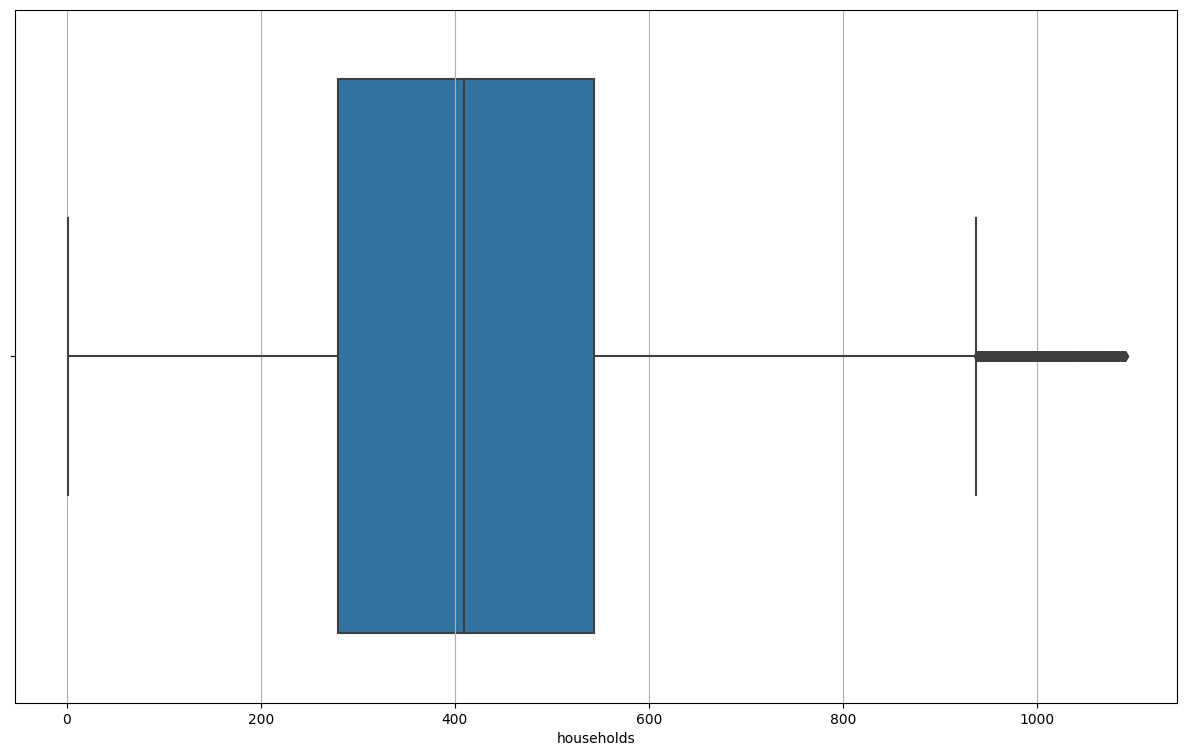

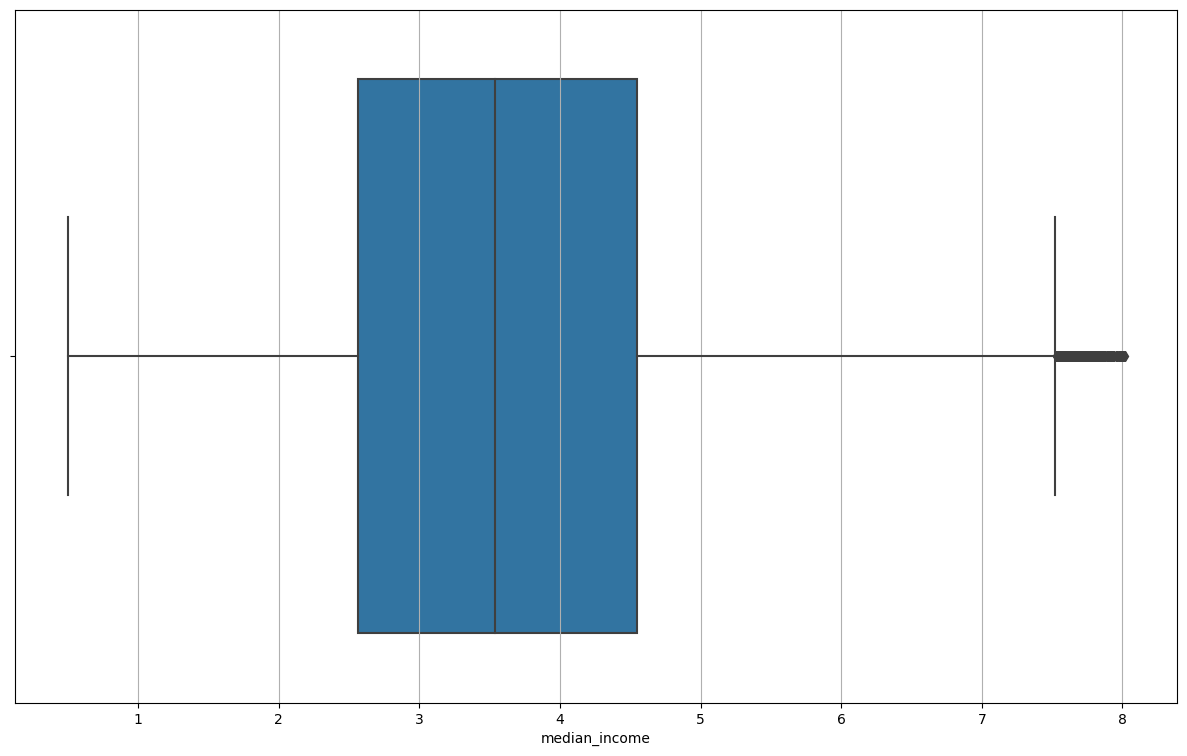

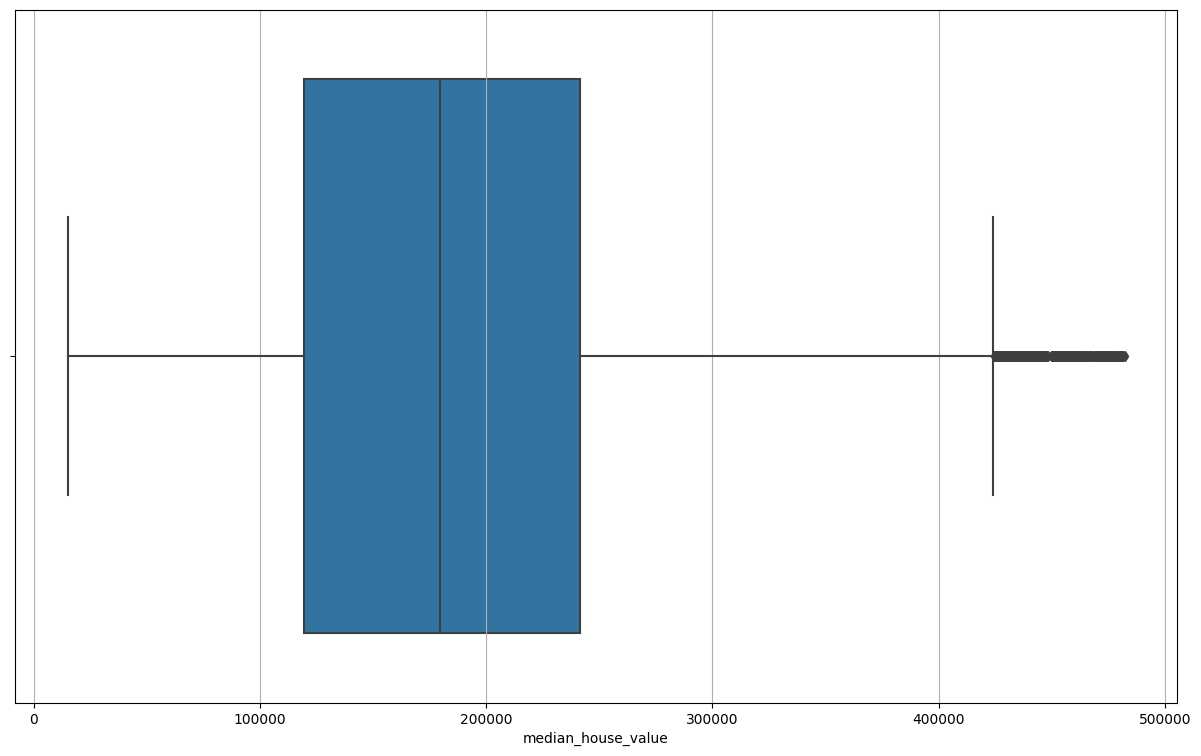

In [18]:
check_outliers(df)

## When extracting features from existing ones and comparing them, then i dropped the one that has less correlation 

In [19]:
df = df.drop(['total_bedrooms','rooms_per_householder','population'],axis=1)
df

longitude  latitude  housing_median_age  total_rooms  households  \
0        -122.23     37.88                41.0   880.000000  126.000000   
1        -122.22     37.86                21.0  2636.504233  499.433465   
2        -122.24     37.85                52.0  1467.000000  177.000000   
3        -122.25     37.85                52.0  1274.000000  219.000000   
4        -122.25     37.85                52.0  1627.000000  259.000000   
...          ...       ...                 ...          ...         ...   
20635    -121.09     39.48                25.0  1665.000000  330.000000   
20636    -121.21     39.49                18.0   697.000000  114.000000   
20637    -121.22     39.43                17.0  2254.000000  433.000000   
20638    -121.32     39.43                18.0  1860.000000  349.000000   
20639    -121.24     39.37                16.0  2785.000000  530.000000   

       median_income  median_house_value  <1H OCEAN  INLAND  ISLAND  NEAR BAY  \
0           3.871162            452600.0        0.0     0.0     0.0       1.0   
1           3.871162            358500.0        0.0     0.0     0.0       1.0   
2           7.257400            352100.0        0.0     0.0     0.0       1.0   
3           5.643100            341300.0        0.0     0.0     0.0       1.0   
4           3.846200            342200.0        0.0     0.0     0.0       1.0   
...              ...                 ...        ...     ...     ...       ...   
20635       1.560300             78100.0        NaN     NaN     NaN       NaN   
20636       2.556800             77100.0        NaN     NaN     NaN       NaN   
20637       1.700000             92300.0        NaN     NaN     NaN       NaN   
20638       1.867200             84700.0        NaN     NaN     NaN       NaN   
20639       2.388600             89400.0        NaN     NaN     NaN       NaN   

       NEAR OCEAN  bedrooms_per_room  population_per_household  
0             0.0           0.146591                  2.555556  
1             0.0           0.155797                  2.109842  
2             0.0           0.129516                  2.802260  
3             0.0           0.184458                  2.547945  
4             0.0           0.172096                  2.181467  
...           ...                ...                       ...  
20635         NaN           0.224625                  2.560606  
20636         NaN           0.215208                  3.122807  
20637         NaN           0.215173                  2.325635  
20638         NaN           0.219892                  2.123209  
20639         NaN           0.221185                  2.616981  

[20433 rows x 14 columns]

In [20]:
df = df.fillna(0)
df

longitude  latitude  housing_median_age  total_rooms  households  \
0        -122.23     37.88                41.0   880.000000  126.000000   
1        -122.22     37.86                21.0  2636.504233  499.433465   
2        -122.24     37.85                52.0  1467.000000  177.000000   
3        -122.25     37.85                52.0  1274.000000  219.000000   
4        -122.25     37.85                52.0  1627.000000  259.000000   
...          ...       ...                 ...          ...         ...   
20635    -121.09     39.48                25.0  1665.000000  330.000000   
20636    -121.21     39.49                18.0   697.000000  114.000000   
20637    -121.22     39.43                17.0  2254.000000  433.000000   
20638    -121.32     39.43                18.0  1860.000000  349.000000   
20639    -121.24     39.37                16.0  2785.000000  530.000000   

       median_income  median_house_value  <1H OCEAN  INLAND  ISLAND  NEAR BAY  \
0           3.871162            452600.0        0.0     0.0     0.0       1.0   
1           3.871162            358500.0        0.0     0.0     0.0       1.0   
2           7.257400            352100.0        0.0     0.0     0.0       1.0   
3           5.643100            341300.0        0.0     0.0     0.0       1.0   
4           3.846200            342200.0        0.0     0.0     0.0       1.0   
...              ...                 ...        ...     ...     ...       ...   
20635       1.560300             78100.0        0.0     0.0     0.0       0.0   
20636       2.556800             77100.0        0.0     0.0     0.0       0.0   
20637       1.700000             92300.0        0.0     0.0     0.0       0.0   
20638       1.867200             84700.0        0.0     0.0     0.0       0.0   
20639       2.388600             89400.0        0.0     0.0     0.0       0.0   

       NEAR OCEAN  bedrooms_per_room  population_per_household  
0             0.0           0.146591                  2.555556  
1             0.0           0.155797                  2.109842  
2             0.0           0.129516                  2.802260  
3             0.0           0.184458                  2.547945  
4             0.0           0.172096                  2.181467  
...           ...                ...                       ...  
20635         0.0           0.224625                  2.560606  
20636         0.0           0.215208                  3.122807  
20637         0.0           0.215173                  2.325635  
20638         0.0           0.219892                  2.123209  
20639         0.0           0.221185                  2.616981  

[20433 rows x 14 columns]